In [1]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from dataset import TinyShakes

from cosmosis.model import GPT
from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
# load dataset
ds_param = {'transforms': {'X1': [AsTensor()], # target
                           'X2': [AsTensor()]},
            'block_size': 10}

ts = TinyShakes(**ds_param)

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  338015
data.nbytes:  676050
CDataset created...


In [3]:
# examine dataset
data = ts[1000]

print(data)
print(data['X1'].shape)
print(type(data['X1']))
print(data['X1'].dtype)

{'X1': tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]), 'X2': tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510])}
torch.Size([10])
<class 'torch.Tensor'>
torch.int64


In [4]:
# load model
model_param = {'device': 'cpu',
               'd_model': 8, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': False, # softmax
               'tokens': False, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (50304, 8, None, True),
                               'X2': (50304, 8, None, True)}} 

gpt = GPT(model_param)

CModel loaded...


In [5]:
# load single data example into model and examine output
out = gpt(data)
print(out)
print(out.shape)
print(out.dtype)

tensor([[-0.7371,  0.0000,  0.6966,  ...,  0.2625, -0.3137, -0.2648],
        [ 1.3190,  0.2147, -0.2437,  ...,  0.0222, -0.1094, -0.2302],
        [ 0.6490,  0.5898,  0.5312,  ..., -0.1855, -0.3606, -0.4096],
        ...,
        [-0.7966, -0.3374,  0.8750,  ..., -0.1090,  0.0000, -0.0000],
        [ 0.9414,  0.2190,  0.0000,  ..., -0.6803, -0.0950, -0.7418],
        [-0.0000, -0.1787,  1.0448,  ..., -1.2817,  0.0326, -1.3436]],
       grad_fn=<MulBackward0>)
torch.Size([10, 50304])
torch.float32


In [6]:
# load generated logits and target tokens into loss function
cel_func = CrossEntropyLoss()
prompt_tokens = data['X2']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['X1']
target_tokens.unsqueeze(0)
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out
generated_tokens.unsqueeze(0)
print('generated_tokens: ', generated_tokens.unsqueeze(0), generated_tokens.shape, generated_tokens.dtype)

loss = cel_func(generated_tokens, target_tokens)
print('loss: ', loss)

prompt_tokens:  tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510]) torch.Size([10]) torch.int64
target_tokens:  tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]) torch.Size([10]) torch.int64
generated_tokens:  tensor([[[-0.7371,  0.0000,  0.6966,  ...,  0.2625, -0.3137, -0.2648],
         [ 1.3190,  0.2147, -0.2437,  ...,  0.0222, -0.1094, -0.2302],
         [ 0.6490,  0.5898,  0.5312,  ..., -0.1855, -0.3606, -0.4096],
         ...,
         [-0.7966, -0.3374,  0.8750,  ..., -0.1090,  0.0000, -0.0000],
         [ 0.9414,  0.2190,  0.0000,  ..., -0.6803, -0.0950, -0.7418],
         [-0.0000, -0.1787,  1.0448,  ..., -1.2817,  0.0326, -1.3436]]],
       grad_fn=<UnsqueezeBackward0>) torch.Size([10, 50304]) torch.float32
loss:  tensor(10.9145, grad_fn=<NllLossBackward0>)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  676050
CDataset created...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:09.119500
epoch: 0, lr: 0.01
train loss: 0.31699543300716354, val loss: 0.25486904713842606
last targets: 
Thy mother rather feel thy pride than fear
Thy dangerous stoutness, for I mock at death
With as big heart as thou. Do as thou list
Thy valiantness was mine, thou suck'dst it from me,

last predictions: 
,:. in:.:,!
,: the, the,

 to..
.
 the.
,: the
,.
,:. of
,; to I
,
 and:,-

...........................
learning time: 0:00:24.750151
epoch: 2, lr: 0.01
train loss: 0.19351237943802757, val loss: 0.19343719548649257
last targets: 
FORD:
Ay, for if Edward repossess the crown,
'Tis like that Richmond with the rest shall down.

SOMERSET:
It shall be so; he shall to Brittany.
Come, therefore
last predictions: 
.?:
 thy,
 is tho

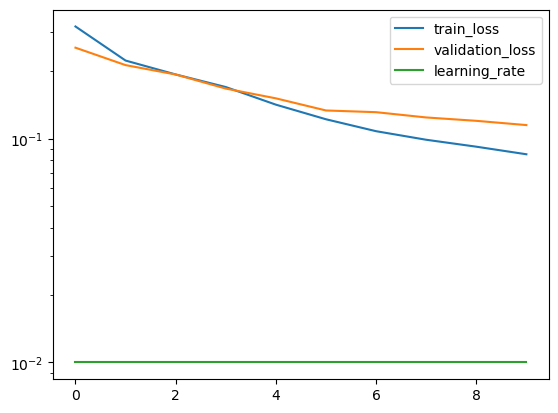

In [7]:
# put all together in a learner
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 50,
                            'n': 1000}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=24, epochs=10, gpu=True, squeeze_y_pred=True, target='X1')